# RNN

## Imports / Settings

In [2]:
%pip install dotenv
%pip install spacy
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.9 MB 5.6 MB/s eta 0:00:03
   ------ --------------------------------- 2.4/13.9 MB 6.4 MB/s eta 0:00:02
   ------------ --------------------------- 4.2/13.9 MB 7.2 MB/s eta 0:00:02
   ------------------ --------------------- 6.3/13.9 MB 8.4 MB/s eta 0:00:01
   ------------------ --------------------- 6.3/13.9 MB 8.4 MB/s eta 0:00:01
   ------------------------ --------------- 8.7/13.9 MB 7.0 MB/s eta 0:00:01
   ---------------------------------- ----- 12.1/13.9 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 13.9/13.9 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/632.6 kB ? eta -:--:--
   --------------------------------------- 632.6/632.6 kB 23.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.0 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.3.0 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------- -------------------------------- 2.4/12.8 MB 16.8 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 46.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 34.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
from tqdm import tqdm
import re

import spacy
import time

from utils.evaluationUtility import analyze_all_results

In [4]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')

Using GPU: NVIDIA RTX A6000


## Data

In [6]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, vocabulary=None):
        self.texts = texts
        self.labels = labels
        self.vocabulary = vocabulary

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.vocabulary.numericalize(self.texts[idx])), torch.tensor(self.labels[idx])
    
def pad_collate(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(x) for x in texts])
    padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, lengths, torch.tensor(labels).float()

In [8]:
class TokenizedSentimentDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = [torch.tensor(label, dtype=torch.float) for label in labels]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## Tokenizer

In [9]:
def simple_tokenizer(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    return text.split()

class Vocabulary:
    def __init__(self, texts, tokenizer, min_freq=2):
        self.tokenizer = tokenizer
        counter = Counter()
        for text in texts:
            counter.update(self.tokenizer(text))
        
        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in counter.items():
            if freq >= min_freq:
                self.stoi[word] = len(self.stoi)
        self.itos = {i: s for s, i in self.stoi.items()}

    def numericalize(self, text):
        return [self.stoi.get(word, self.stoi["<UNK>"]) for word in self.tokenizer(text)]
    
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    return [token.text for token in nlp(text) if not token.is_punct and not token.is_space]

class TokenizedVocabulary:
    def __init__(self, tokenized_texts, min_freq=2):
        counter = Counter()
        for tokens in tokenized_texts:
            counter.update(tokens)

        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in counter.items():
            if freq >= min_freq:
                self.stoi[word] = len(self.stoi)
        self.itos = {i: s for s, i in self.stoi.items()}

    def numericalize(self, tokens):
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

## Embedding

In [10]:
def load_glove_embeddings(vocab, glove_path="glove.6B.100d.txt", dim=100):
    embeddings_index = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(vocab.stoi), dim)  # Random init
    for word, idx in vocab.stoi.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]

    return embedding_matrix

## Classifier

In [11]:
class RNNSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=bidirectional, batch_first=True, dropout=dropout, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        embedded = self.dropout(self.embedding(x))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        return self.fc(hidden).squeeze()

## Metrics

In [12]:
def calculate_metrics(model, data_loader, device='cuda'):
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, lengths, y in data_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            predictions = model(x, lengths)
            
            preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    
    return precision, recall, f1

def measure_inference_time(model, data_loader, device='cuda'):
    model.eval()
    total_time = 0
    n_samples = 0
    with torch.no_grad():
        for inputs, lengths, _ in data_loader:
            inputs = inputs.to(device)
            n_samples += inputs.size(0)
            start = time.time()
            _ = model(inputs, lengths)
            end = time.time()
            total_time += (end - start)
    return total_time

def evaluate_model(model, model_name, classifier_name, vectorizer_name, training_duration, val_data_loader, test_data_loader, device='cuda'):
    val_precision, val_recall, val_f1 = calculate_metrics(model, val_data_loader, device)
    test_precision, test_recall, test_f1 = calculate_metrics(model, test_data_loader, device)
    
    inference_time = measure_inference_time(model, test_data_loader, device)
    
    result = {
        'classifier': classifier_name,
        'vectorizer': vectorizer_name,
        'val_accuracy': None,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'test_accuracy': None,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'training_duration': training_duration,
        'inference_time': inference_time,
    }

    results_name = f"executions/{model_name}/{classifier_name}_{vectorizer_name}"
    result_df = pd.DataFrame([result])
    result_df.to_csv(f"{results_name}.csv", index=False)

## Training

In [13]:
def train_model(model, train_loader, val_loader, epochs=5):
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)
    criterion.to(device)

    start_time = time.time()

    for epoch in range(epochs):
        # ====== Training =====
        model.train()
        train_loss, _ = 0, 0
        for x, lengths, y in tqdm(train_loader):
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            predictions = model(x, lengths)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # ====== Validation =====
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, lengths, y in val_loader:
                x, lengths, y = x.to(device), lengths.to(device), y.to(device)
                predictions = model(x, lengths)
                loss = criterion(predictions, y)
                val_loss += loss.item()

                preds = torch.round(torch.sigmoid(predictions))
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average="weighted", zero_division=0
        )

        print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f} | "
              f"Val Loss: {val_loss / len(val_loader):.4f} | "
              f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f}")

    end_time = time.time()
    return end_time - start_time

### RNN with simple tokenizer

In [14]:
vocabulary = Vocabulary(texts=train_texts, tokenizer=simple_tokenizer)

train_dataset = SentimentDataset(train_texts, train_labels, vocabulary)
val_dataset = SentimentDataset(validation_texts, validation_labels, vocabulary)
test_dataset = SentimentDataset(test_texts, test_labels, vocabulary)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

#### 5 epochs, hidden dimension 128

In [15]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SimpleTokenizer-5e-128h", 
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [00:36<00:00, 124.14it/s]


Epoch 1 | Train Loss: 0.5954 | Val Loss: 0.5044 | P: 0.7561 R: 0.7552 F1: 0.7556


100%|██████████| 4500/4500 [00:35<00:00, 125.58it/s]


Epoch 2 | Train Loss: 0.5293 | Val Loss: 0.5062 | P: 0.7657 R: 0.7671 F1: 0.7657


100%|██████████| 4500/4500 [00:35<00:00, 125.60it/s]


Epoch 3 | Train Loss: 0.5006 | Val Loss: 0.4692 | P: 0.7785 R: 0.7788 F1: 0.7787


100%|██████████| 4500/4500 [00:35<00:00, 125.86it/s]


Epoch 4 | Train Loss: 0.4761 | Val Loss: 0.4743 | P: 0.7854 R: 0.7862 F1: 0.7857


100%|██████████| 4500/4500 [00:35<00:00, 125.78it/s]


Epoch 5 | Train Loss: 0.4615 | Val Loss: 0.4661 | P: 0.7835 R: 0.7845 F1: 0.7836


#### 10 epochs, hidden dimension 128

In [16]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SimpleTokenizer-10e-128h",
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [00:35<00:00, 125.89it/s]


Epoch 1 | Train Loss: 0.5997 | Val Loss: 0.5153 | P: 0.7484 R: 0.7500 F1: 0.7483


100%|██████████| 4500/4500 [00:35<00:00, 125.77it/s]


Epoch 2 | Train Loss: 0.5229 | Val Loss: 0.4843 | P: 0.7680 R: 0.7692 F1: 0.7671


100%|██████████| 4500/4500 [00:35<00:00, 125.23it/s]


Epoch 3 | Train Loss: 0.4925 | Val Loss: 0.4703 | P: 0.7796 R: 0.7806 F1: 0.7798


100%|██████████| 4500/4500 [00:36<00:00, 124.76it/s]


Epoch 4 | Train Loss: 0.4743 | Val Loss: 0.4606 | P: 0.7826 R: 0.7835 F1: 0.7828


100%|██████████| 4500/4500 [00:35<00:00, 125.21it/s]


Epoch 5 | Train Loss: 0.4595 | Val Loss: 0.4569 | P: 0.7848 R: 0.7847 F1: 0.7847


100%|██████████| 4500/4500 [00:35<00:00, 125.35it/s]


Epoch 6 | Train Loss: 0.4473 | Val Loss: 0.4514 | P: 0.7893 R: 0.7895 F1: 0.7894


100%|██████████| 4500/4500 [00:35<00:00, 125.66it/s]


Epoch 7 | Train Loss: 0.4377 | Val Loss: 0.4512 | P: 0.7913 R: 0.7917 F1: 0.7914


100%|██████████| 4500/4500 [00:35<00:00, 125.20it/s]


Epoch 8 | Train Loss: 0.4298 | Val Loss: 0.4542 | P: 0.7908 R: 0.7916 F1: 0.7899


100%|██████████| 4500/4500 [00:35<00:00, 125.72it/s]


Epoch 9 | Train Loss: 0.4235 | Val Loss: 0.4472 | P: 0.7934 R: 0.7937 F1: 0.7935


100%|██████████| 4500/4500 [00:35<00:00, 125.13it/s]


Epoch 10 | Train Loss: 0.4179 | Val Loss: 0.4523 | P: 0.7937 R: 0.7934 F1: 0.7935


#### 5 epochs, hidden dimension 256

In [17]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

training_time = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SimpleTokenizer-5e-256h",
    training_duration=training_time, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4500/4500 [00:36<00:00, 122.46it/s]


Epoch 1 | Train Loss: 0.6186 | Val Loss: 0.5317 | P: 0.7296 R: 0.7317 F1: 0.7281


100%|██████████| 4500/4500 [00:36<00:00, 122.10it/s]


Epoch 2 | Train Loss: 0.5429 | Val Loss: 0.4949 | P: 0.7587 R: 0.7595 F1: 0.7589


100%|██████████| 4500/4500 [00:36<00:00, 123.37it/s]


Epoch 3 | Train Loss: 0.5114 | Val Loss: 0.5053 | P: 0.7600 R: 0.7613 F1: 0.7602


100%|██████████| 4500/4500 [00:36<00:00, 123.25it/s]


Epoch 4 | Train Loss: 0.4933 | Val Loss: 0.4778 | P: 0.7716 R: 0.7723 F1: 0.7719


100%|██████████| 4500/4500 [00:36<00:00, 122.53it/s]


Epoch 5 | Train Loss: 0.4820 | Val Loss: 0.4816 | P: 0.7708 R: 0.7710 F1: 0.7675


### RNN with spaCy tokenizer and GloVe embedding

In [18]:
tokenized_train_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(train_texts, batch_size=64)
]

tokenized_val_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(validation_texts, batch_size=64)
]

tokenized_test_texts = [
    [token.lemma_.lower() for token in doc if token.is_alpha]
    for doc in nlp.pipe(test_texts, batch_size=64)
]

In [19]:
vocabulary = TokenizedVocabulary(tokenized_train_texts, min_freq=2)

In [23]:
embedding_matrix = load_glove_embeddings(vocabulary)

In [24]:
filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_train_texts, train_labels)
    if len(tokens) > 0
]
train_inputs, train_labels = zip(*filtered)

filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_val_texts, validation_labels)
    if len(tokens) > 0
]
val_inputs, validation_labels = zip(*filtered)

filtered = [
    (torch.tensor(vocabulary.numericalize(tokens), dtype=torch.long), label)
    for tokens, label in zip(tokenized_test_texts, test_labels)
    if len(tokens) > 0
]
test_inputs, test_labels = zip(*filtered)

In [25]:
train_dataset = TokenizedSentimentDataset(train_inputs, train_labels)
val_dataset = TokenizedSentimentDataset(val_inputs, validation_labels)
test_dataset = TokenizedSentimentDataset(test_inputs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=8, pin_memory=True)

#### 5 epochs, hidden dimension 128

In [ ]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SpacyTokenizer-5e-128h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:35<00:00, 127.50it/s]


Epoch 1 | Train Loss: 0.5563 | Val Loss: 0.4804 | P: 0.7696 R: 0.7704 F1: 0.7699


100%|██████████| 4489/4489 [00:35<00:00, 127.35it/s]


Epoch 2 | Train Loss: 0.4972 | Val Loss: 0.4686 | P: 0.7725 R: 0.7738 F1: 0.7718


100%|██████████| 4489/4489 [00:34<00:00, 131.00it/s]


Epoch 3 | Train Loss: 0.4763 | Val Loss: 0.4582 | P: 0.7809 R: 0.7815 F1: 0.7811


100%|██████████| 4489/4489 [00:34<00:00, 128.90it/s]


Epoch 4 | Train Loss: 0.4615 | Val Loss: 0.4549 | P: 0.7844 R: 0.7842 F1: 0.7843


100%|██████████| 4489/4489 [00:34<00:00, 129.30it/s]


Epoch 5 | Train Loss: 0.4504 | Val Loss: 0.4577 | P: 0.7841 R: 0.7813 F1: 0.7821


#### 10 epochs, hidden dimension 128

In [27]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SpacyTokenizer-10e-128h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:35<00:00, 127.00it/s]


Epoch 1 | Train Loss: 0.5565 | Val Loss: 0.4816 | P: 0.7694 R: 0.7703 F1: 0.7697


100%|██████████| 4489/4489 [00:34<00:00, 130.19it/s]


Epoch 2 | Train Loss: 0.5018 | Val Loss: 0.4879 | P: 0.7704 R: 0.7716 F1: 0.7694


100%|██████████| 4489/4489 [00:34<00:00, 129.79it/s]


Epoch 3 | Train Loss: 0.4809 | Val Loss: 0.4634 | P: 0.7811 R: 0.7812 F1: 0.7812


100%|██████████| 4489/4489 [00:34<00:00, 130.00it/s]


Epoch 4 | Train Loss: 0.4634 | Val Loss: 0.4576 | P: 0.7802 R: 0.7814 F1: 0.7798


100%|██████████| 4489/4489 [00:34<00:00, 131.00it/s]


Epoch 5 | Train Loss: 0.4523 | Val Loss: 0.4584 | P: 0.7849 R: 0.7809 F1: 0.7819


100%|██████████| 4489/4489 [00:34<00:00, 129.55it/s]


Epoch 6 | Train Loss: 0.4440 | Val Loss: 0.4551 | P: 0.7831 R: 0.7833 F1: 0.7831


100%|██████████| 4489/4489 [00:34<00:00, 128.91it/s]


Epoch 7 | Train Loss: 0.4393 | Val Loss: 0.4650 | P: 0.7885 R: 0.7800 F1: 0.7813


100%|██████████| 4489/4489 [00:35<00:00, 126.27it/s]


Epoch 8 | Train Loss: 0.4329 | Val Loss: 0.4728 | P: 0.7868 R: 0.7732 F1: 0.7747


100%|██████████| 4489/4489 [00:34<00:00, 129.38it/s]


Epoch 9 | Train Loss: 0.4270 | Val Loss: 0.4521 | P: 0.7835 R: 0.7846 F1: 0.7836


100%|██████████| 4489/4489 [00:34<00:00, 129.00it/s]


Epoch 10 | Train Loss: 0.4252 | Val Loss: 0.4562 | P: 0.7839 R: 0.7833 F1: 0.7836


#### 5 epochs, hidden dimension 256

In [28]:
model = RNNSentimentClassifier(
    vocab_size=len(vocabulary.stoi),
    embed_dim=100,
    hidden_dim=256,
    output_dim=1,
    num_layers=2,
    bidirectional=True,
    dropout=0.5
)

model.embedding.weight.data.copy_(embedding_matrix)
training_duration = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=5)

evaluate_model(
    model=model, 
    model_name="rnn", 
    classifier_name="RNN", 
    vectorizer_name="SpacyTokenizer-5e-256h", 
    training_duration=training_duration, 
    val_data_loader=val_loader, 
    test_data_loader=test_loader)

100%|██████████| 4489/4489 [00:35<00:00, 127.49it/s]


Epoch 1 | Train Loss: 0.5734 | Val Loss: 0.4992 | P: 0.7643 R: 0.7595 F1: 0.7607


100%|██████████| 4489/4489 [00:35<00:00, 127.49it/s]


Epoch 2 | Train Loss: 0.5213 | Val Loss: 0.4759 | P: 0.7751 R: 0.7739 F1: 0.7743


100%|██████████| 4489/4489 [00:35<00:00, 127.81it/s]


Epoch 3 | Train Loss: 0.4917 | Val Loss: 0.4816 | P: 0.7822 R: 0.7707 F1: 0.7722


100%|██████████| 4489/4489 [00:35<00:00, 126.01it/s]


Epoch 4 | Train Loss: 0.4750 | Val Loss: 0.4671 | P: 0.7772 R: 0.7774 F1: 0.7773


100%|██████████| 4489/4489 [00:35<00:00, 126.68it/s]


Epoch 5 | Train Loss: 0.4679 | Val Loss: 0.4686 | P: 0.7775 R: 0.7785 F1: 0.7764


In [3]:
from utils.evaluationUtility import analyze_all_results

Failed to load confusion matrix for RNN_SimpleTokenizer-10e-128h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SimpleTokenizer-10e-128h_val_confusion.json'
Failed to load confusion matrix for RNN_SimpleTokenizer-5e-128h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SimpleTokenizer-5e-128h_val_confusion.json'
Failed to load confusion matrix for RNN_SimpleTokenizer-5e-256h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SimpleTokenizer-5e-256h_val_confusion.json'
Failed to load confusion matrix for RNN_SpacyTokenizer-10e-128h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SpacyTokenizer-10e-128h_val_confusion.json'
Failed to load confusion matrix for RNN_SpacyTokenizer-5e-128h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SpacyTokenizer-5e-128h_val_confusion.json'
Failed to load confusion matrix for RNN_SpacyTokenizer-5e-256h: [Errno 2] No such file or directory: 'executions/rnn\\RNN_SpacyTokenizer-5e-256h_val_confusion.json'


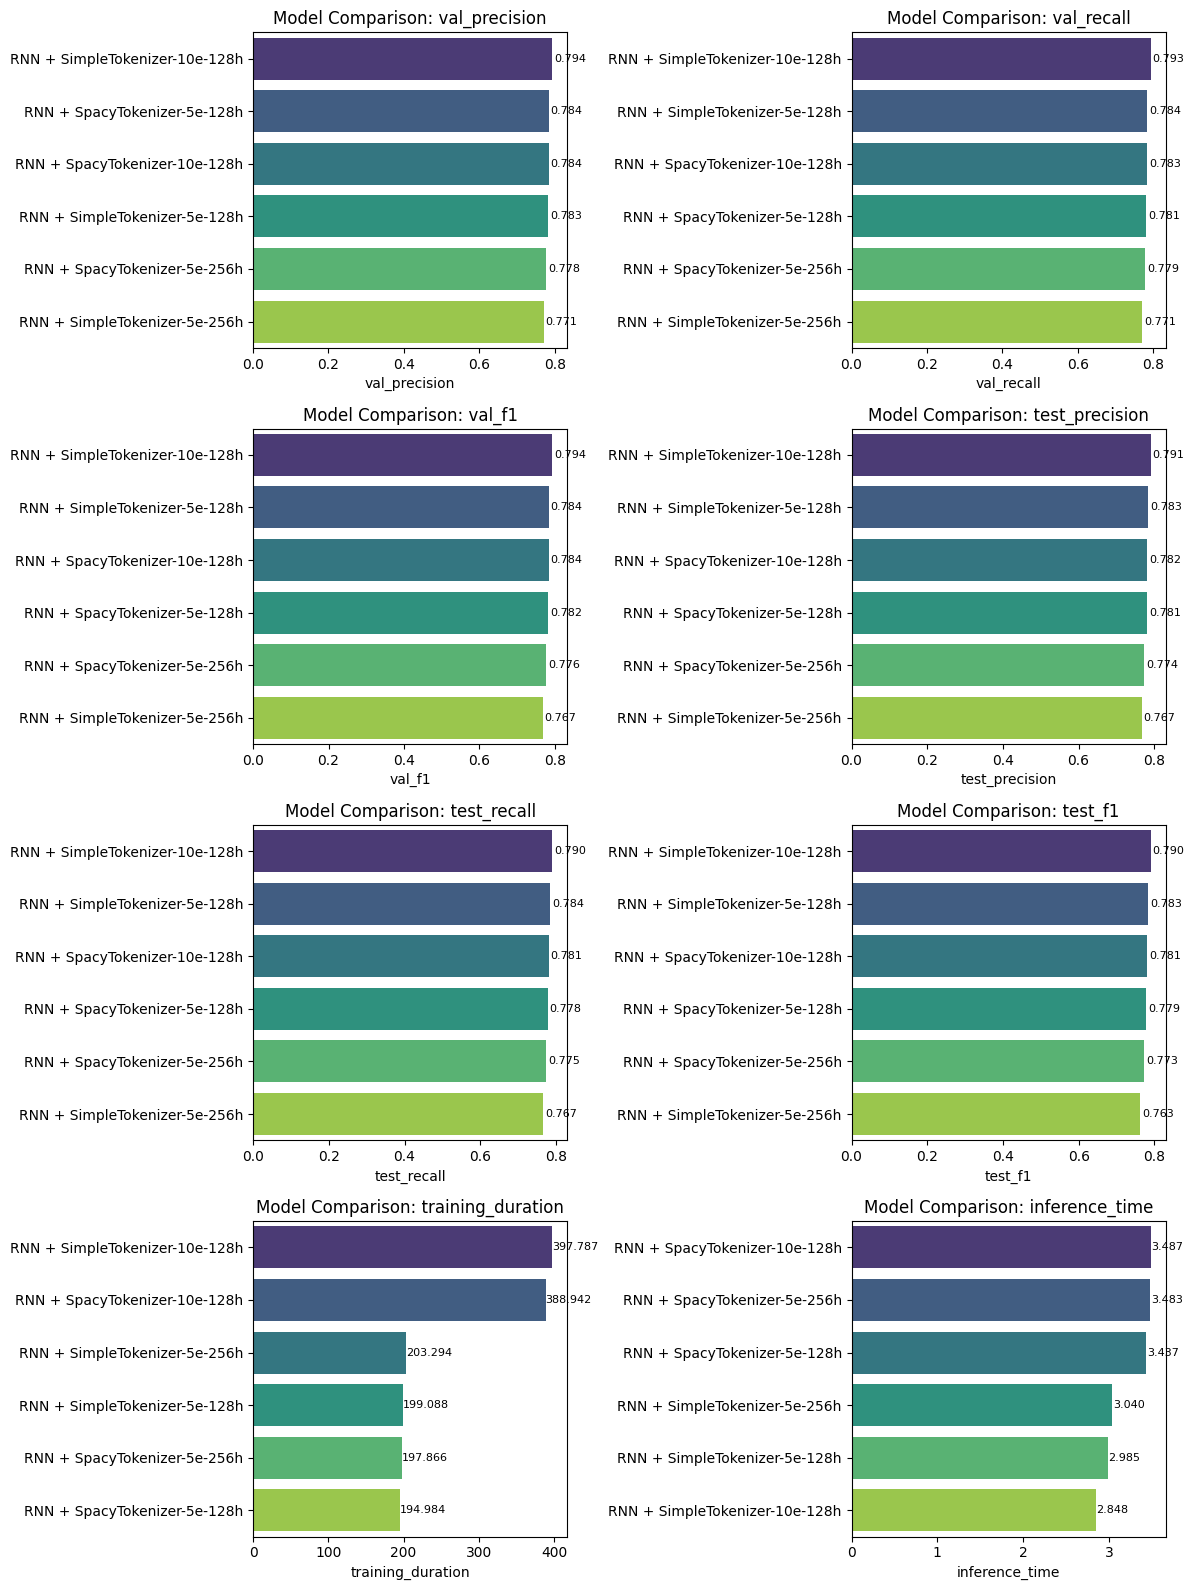

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,inference_time,Classifier,Vectorizer,Model
0,RNN,SimpleTokenizer-10e-128h,NaN,0.793740,0.793355,0.793526,NaN,0.790757,0.790240,0.790461,397.787483,2.847927,RNN,SimpleTokenizer-10e-128h,RNN + SimpleTokenizer-10e-128h
1,RNN,SimpleTokenizer-5e-128h,NaN,0.783465,0.784494,0.783565,NaN,0.783262,0.784240,0.783367,199.088210,2.984923,RNN,SimpleTokenizer-5e-128h,RNN + SimpleTokenizer-5e-128h
2,RNN,SimpleTokenizer-5e-256h,NaN,0.770793,0.771021,0.767494,NaN,0.766599,0.766639,0.762863,203.293771,3.039798,RNN,SimpleTokenizer-5e-256h,RNN + SimpleTokenizer-5e-256h
3,RNN,SpacyTokenizer-10e-128h,NaN,0.783873,0.783311,0.783552,NaN,0.781665,0.780869,0.781192,388.942069,3.486611,RNN,SpacyTokenizer-10e-128h,RNN + SpacyTokenizer-10e-128h
4,RNN,SpacyTokenizer-5e-128h,NaN,0.784137,0.781278,0.782101,NaN,0.780754,0.778040,0.778833,194.984041,3.436517,RNN,SpacyTokenizer-5e-128h,RNN + SpacyTokenizer-5e-128h
5,RNN,SpacyTokenizer-5e-256h,NaN,0.777522,0.778548,0.776438,NaN,0.773818,0.774811,0.772606,197.866385,3.483238,RNN,SpacyTokenizer-5e-256h,RNN + SpacyTokenizer-5e-256h


In [4]:
analyze_all_results(results_dir="executions/rnn")